In [1]:
# Grundlegende Bibliotheken
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import missingno as msno

# Einstellungen für bessere Plots
plt.rcParams['figure.figsize'] = (10, 6)

# Pandas Optionen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)

# Download latest version


path = kagglehub.dataset_download("priyamchoksi/credit-card-transactions-dataset")

ds = pd.read_csv(f"{path}/credit_card_transactions.csv")

print(f"Anzahl Zeilen: {ds.shape[0]}")
print(f"Anzahl Spalten: {ds.shape[1]}")

Anzahl Zeilen: 1296675
Anzahl Spalten: 24


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

summary = ds.groupby('state').agg(
    transactions=('is_fraud', 'count'),
    frauds=('is_fraud', 'sum')
).reset_index()

#Berechnen der Betrugsquote (%) und den Anteil an den Gesamttransaktionen
summary['fraud_rate'] = (summary['frauds'] / summary['transactions']) * 100
summary['transaction_share'] = summary['transactions'] / summary['transactions'].sum()

# Grundlegende Choroplethenkarte
fig = px.choropleth(
    summary,
    locations='state',
    locationmode='USA-states',
    color='transaction_share',
    color_continuous_scale='Blues',
    scope='usa',
    hover_data={
        'fraud_rate': ':.2f',
        'transactions': True,
        'frauds': True,
        'transaction_share': ':.2%'
    },
)

# Textbeschriftungen (Betrugsrate in %) mithilfe integrierter Zustandszentren hinzufügen
# Plotly stellt integrierte Geometrieinformationen über `plotly.express.data.us_10m` bereit
import json
from urllib.request import urlopen

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

state_centers = pd.read_csv('https://raw.githubusercontent.com/jasonong/List-of-US-States/master/states.csv')
# state_centers enthält Spalten: Bundesstaat, Abkürzung
# Wir benötigen die Breiten- und Längengrade für diese Abkürzungen
state_latlon = pd.DataFrame({
    'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
              'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
              'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'lat': [32.8067,61.3707,33.7298,34.9697,36.1162,39.0598,41.5978,39.3185,27.7663,33.0406,21.0943,44.2405,40.3495,39.8494,
            42.0115,38.5266,37.6681,31.1695,44.6939,39.0639,42.2302,43.3266,45.6945,32.7416,38.4561,46.9219,41.1254,38.3135,
            43.4525,40.2989,34.8405,42.1657,35.6301,47.5289,40.3888,35.5653,44.5720,40.5908,41.6809,41.6809,44.2998,35.7478,
            31.0545,40.1500,44.0459,37.7693,47.4009,38.4912,44.2685,42.7559],
    'lon': [-86.7911,-152.4044,-111.4312,-92.3731,-119.6816,-105.3111,-72.7554,-75.5071,-81.6868,-83.6431,-157.4983,
            -114.4788,-88.9861,-86.2583,-93.2105,-96.7265,-84.6701,-91.8678,-69.3819,-76.8021,-71.5301,-84.5361,
            -93.9002,-89.6787,-92.2884,-110.4544,-98.2681,-117.0554,-71.5639,-74.5210,-106.2485,-74.9481,-79.8064,
            -99.7840,-82.7649,-96.9289,-122.0709,-77.2098,-71.5118,-71.5118,-99.4388,-86.6923,-97.5635,-111.8624,
            -72.7093,-78.1699,-120.4472,-80.9545,-89.6165,-107.3025]
})

# Koordinaten zusammenführen
summary = summary.merge(state_latlon, on='state', how='left')

# Textebene hinzufügen
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=summary['lon'],
    lat=summary['lat'],
    text=summary['fraud_rate'].round(1).astype(str) + '%',
    mode='text',
    textfont=dict(color='black', size=6)
))

# Layout
fig.update_layout(
    title_text='🗺️ U.S. Fraud Rate (%) by State<br><sup>Color shows transaction volume share</sup>',
    geo=dict(showlakes=True, lakecolor='lightblue')
)

fig.show()

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Bevölkerungszahlen der Bundesstaaten laut Volkszählung 2020
population_df = pd.DataFrame({
    'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
              'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
              'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'population': [
        5024279,733391,7151502,3011524,39538223,5773714,3605944,989948,21538187,10711908,1455271,
        1839106,12812508,6785528,3190369,2937880,4505836,4657757,1362359,6177224,
        7029917,10077331,5706494,2961279,6154913,1084225,1961504,3104614,1377529,9288994,
        2117522,20201249,10439388,779094,11799448,3959353,4237256,13002700,1097379,5118425,
        886667,6910840,29145505,3271616,643077,8631393,7705281,1793716,5893718,576851
    ]
})

# Ursprüngliche Zusammenfassung
summary = ds.groupby('state').agg(
    transactions=('is_fraud', 'count'),
    frauds=('is_fraud', 'sum')
).reset_index()

summary['fraud_rate'] = (summary['frauds'] / summary['transactions']) * 100

# Bevölkerung zusammenführen
summary = summary.merge(population_df, on='state', how='left')

# --- Kennzahl: Transaktionen pro Einwohner ---
summary['transactions_per_capita'] = summary['transactions'] / summary['population']


# Staatliche Zentren(Unverändert)
state_latlon = pd.DataFrame({
    'state': ['AL','AK','AZ','AR','CA','CO','CT','DE','FL','GA','HI','ID','IL','IN','IA','KS','KY','LA','ME','MD',
              'MA','MI','MN','MS','MO','MT','NE','NV','NH','NJ','NM','NY','NC','ND','OH','OK','OR','PA','RI','SC',
              'SD','TN','TX','UT','VT','VA','WA','WV','WI','WY'],
    'lat': [32.8067,61.3707,33.7298,34.9697,36.1162,39.0598,41.5978,39.3185,27.7663,33.0406,21.0943,
            44.2405,40.3495,39.8494,42.0115,38.5266,37.6681,31.1695,44.6939,39.0639,
            42.2302,43.3266,45.6945,32.7416,38.4561,46.9219,41.1254,38.3135,43.4525,40.2989,
            34.8405,42.1657,35.6301,47.5289,40.3888,35.5653,44.5720,40.5908,41.6809,41.6809,
            44.2998,35.7478,31.0545,40.1500,44.0459,37.7693,47.4009,38.4912,44.2685,42.7559],
    'lon': [-86.7911,-152.4044,-111.4312,-92.3731,-119.6816,-105.3111,-72.7554,-75.5071,-81.6868,-83.6431,-157.4983,
            -114.4788,-88.9861,-86.2583,-93.2105,-96.7265,-84.6701,-91.8678,-69.3819,-76.8021,
            -71.5301,-84.5361,-93.9002,-89.6787,-92.2884,-110.4544,-98.2681,-117.0554,-71.5639,-74.5210,
            -106.2485,-74.9481,-79.8064,-99.7840,-82.7649,-96.9289,-122.0709,-77.2098,-71.5118,-71.5118,
            -99.4388,-86.6923,-97.5635,-111.8624,-72.7093,-78.1699,-120.4472,-80.9545,-89.6165,-107.3025]
})

summary = summary.merge(state_latlon, on='state', how='left')


# Choropleth nach Transaktionen pro Einwohner
fig = px.choropleth(
    summary,
    locations='state',
    locationmode='USA-states',
    color='transactions_per_capita',
    color_continuous_scale='Greens',
    scope='usa',
    hover_data={
        'transactions': True,
        'population': True,
        'transactions_per_capita': ':.6f',
        'fraud_rate': ':.2f'
    }
)


# Textebene (Betrugsrate in %)
fig.add_trace(go.Scattergeo(
    locationmode='USA-states',
    lon=summary['lon'],
    lat=summary['lat'],
    text=summary['fraud_rate'].round(1).astype(str) + '%',
    mode='text',
    textfont=dict(color='black', size=7)
))


fig.update_layout(
    title_text='Transaktionen pro Einwohner (2020 Census)<br><sup>Text zeigt Fraud Rate (%)</sup>',
    geo=dict(showlakes=True, lakecolor='lightblue'),
    width=1200,   # Breite in Pixel
    height=700    # Höhe in Pixel
)

fig.show()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y = ds["is_fraud"]
X = ds[["trans_date_trans_time", "merchant", "category", "amt", "state", "job", "dob"]]

# Datenvorbereitung
X["trans_date_trans_time"] = pd.to_datetime(X["trans_date_trans_time"])
X["dob"] = pd.to_datetime(X["dob"])

X["trans_year"] = X["trans_date_trans_time"].dt.year
X["trans_month"] = X["trans_date_trans_time"].dt.month
X["trans_day"] = X["trans_date_trans_time"].dt.day
X["trans_hour"] = X["trans_date_trans_time"].dt.hour

X["birth_year"] = X["dob"].dt.year
X["age"] = X["trans_year"] - X["birth_year"]

X = X.drop(columns=["trans_date_trans_time", "dob"])

categorical_features = ["merchant", "category", "state", "job"]
numeric_features = ["amt", "trans_year", "trans_month", "trans_day", "trans_hour", "age"]

# One-Hot-Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ],
    remainder="passthrough"  # lässt numerische Spalten unverändert
)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=10000))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45050/2740360695.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45050/2740360695.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/cd/nv3twvx12gx_b15k3sbqkn300000gn/T/ipykernel_45050/2740360695.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

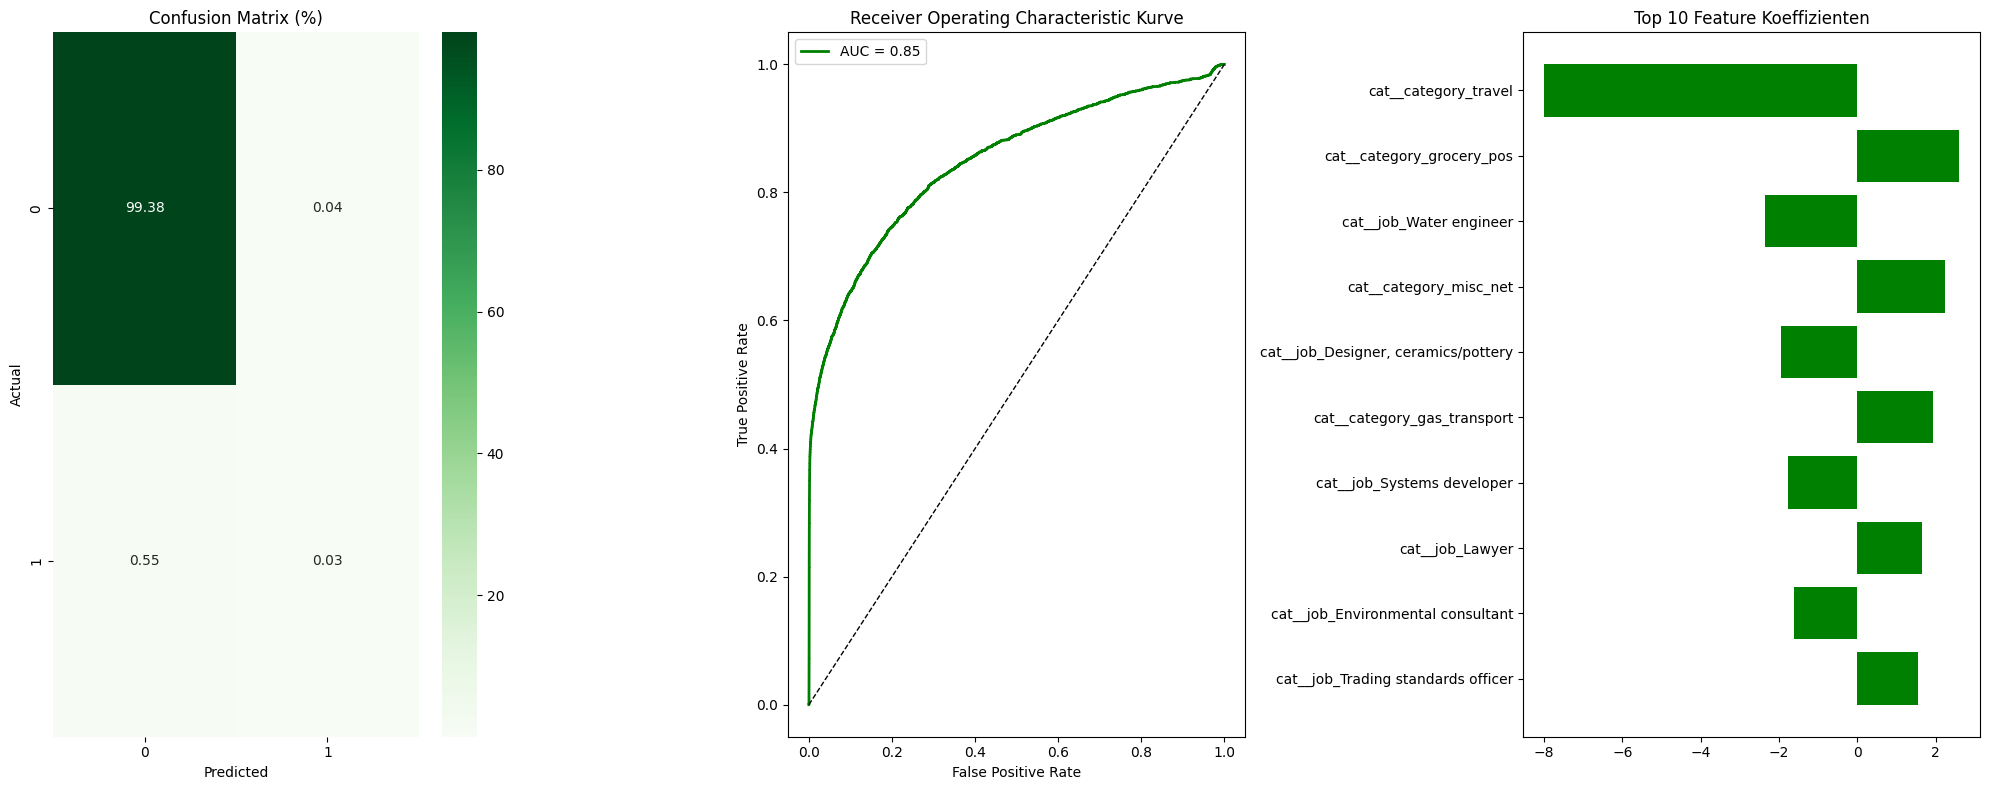

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum() * 100


# ROC-Kurve
y_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)


# Feature Importance (Koeffizienten)

feature_names = model.named_steps['preprocessor'].get_feature_names_out()
coef = model.named_steps['classifier'].coef_[0]

feat_imp = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
feat_imp = feat_imp.reindex(feat_imp.Coefficient.abs().sort_values(ascending=False).index)
top_feat = feat_imp.head(10)  # Top 10 Features

# Figur mit 3 Subplots
fig, axes = plt.subplots(1, 3, figsize=(20,8))

# Confusion Matrix
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Greens", ax=axes[0])
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")
axes[0].set_title("Confusion Matrix (%)")

# ROC-Kurve
axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}', color='green', linewidth=2)
axes[1].plot([0,1], [0,1], 'k--', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic Kurve')
axes[1].legend()

# Top Feature Coefficients
axes[2].barh(top_feat['Feature'], top_feat['Coefficient'], color='Green')
axes[2].invert_yaxis()  # größte Koeffizienten oben
axes[2].set_title('Top 10 Feature Koeffizienten')

plt.tight_layout()
plt.show()

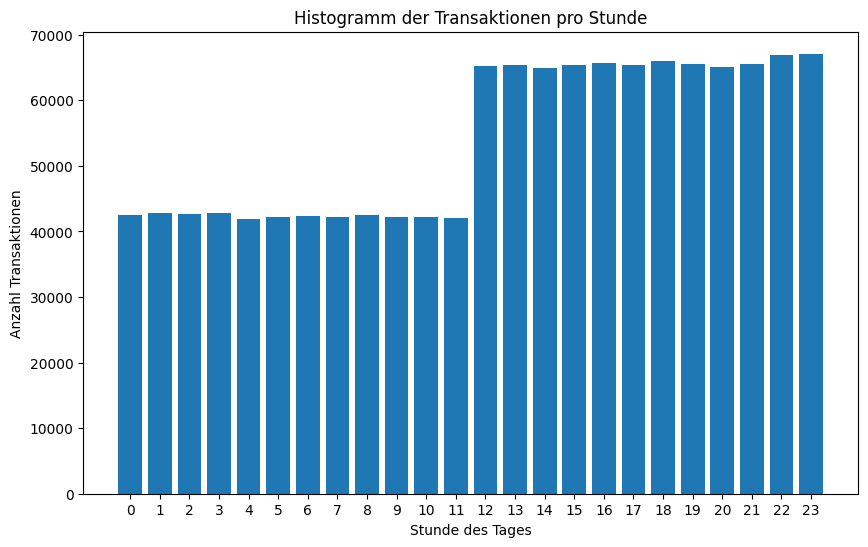

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Unix-Zeit in datetime umwandeln
ds['datetime'] = pd.to_datetime(ds['unix_time'], unit='s')

# Nur die Stunde extrahieren
ds['hour'] = ds['datetime'].dt.hour

# Histogramm: Anzahl der Transaktionen pro Stunde
hour_counts = ds['hour'].value_counts().sort_index()

# Plot
plt.bar(hour_counts.index, hour_counts.values)
plt.xticks(range(24))  # alle Stunden von 0-23 anzeigen
plt.xlabel("Stunde des Tages")
plt.ylabel("Anzahl Transaktionen")
plt.title("Histogramm der Transaktionen pro Stunde")
plt.show()